# MNIST Novelty Detection

In [86]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

from tensorflow.keras.datasets import mnist

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(X_train.shape) # 60K images
print(X_train.dtype) # integer value 0 to 255
print(X_test.shape) # 10K images

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
uint8
(10000, 28, 28)


In [4]:
# Convert int8 to float64
X_train, X_test = X_train/255.0, X_test/255.0

In [5]:
print(X_train.dtype)
print(X_test.dtype)

float64
float64


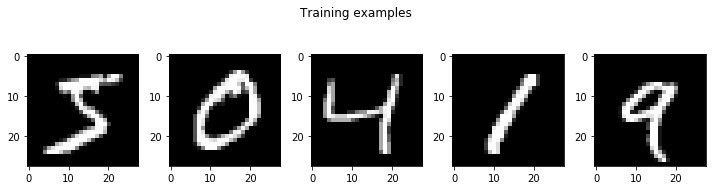

In [24]:
# Training examples
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1, 5, figsize=(10, 3))
fig.suptitle('Training examples')
ax0.imshow(X_train[0].reshape((28, 28)), cmap='gray')
ax1.imshow(X_train[1].reshape((28, 28)), cmap='gray')
ax2.imshow(X_train[2].reshape((28, 28)), cmap='gray')
ax3.imshow(X_train[3].reshape((28, 28)), cmap='gray')
ax4.imshow(X_train[4].reshape((28, 28)), cmap='gray')
plt.tight_layout()

In [25]:
# Training labels
y_train[:5]

array([5, 0, 4, 1, 9], dtype=uint8)

In [26]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(10, activation='softmax'),
])

model.compile(loss='sparse_categorical_crossentropy',
             optimizer=keras.optimizers.SGD(lr=0.01),
             metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                3010      
Total params: 328,810
Trainable params: 328,810
Non-trainable params: 0
_________________________________________________________________


In [27]:
history = model.fit(X_train, y_train, epochs=30,
                    batch_size=32, verbose=0,
                    validation_data=(X_test, y_test)
                   )

In [28]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 0s 28us/sample - loss: 0.0672 - accuracy: 0.9783


[0.06718943581413478, 0.9783]

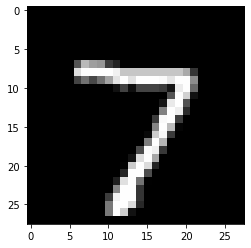

In [29]:
plt.imshow(X_test[0].reshape((28, 28)), cmap='gray')
plt.show()

In [33]:
model.predict(X_test[:1])

array([[4.8109285e-07, 3.9185426e-08, 6.9762747e-05, 3.2190420e-04,
        1.3901094e-09, 8.6965161e-07, 1.0997163e-11, 9.9959320e-01,
        6.8876675e-06, 6.9881703e-06]], dtype=float32)

In [56]:
np.around(model.predict(X_test[:1]), decimals=2)

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], dtype=float32)

In [34]:
model.predict_classes(X_test[:1])

array([7])

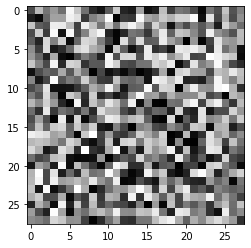

In [154]:
temp2 = np.random.rand(28, 28)
plt.imshow(temp2, cmap='gray')
plt.show()

In [155]:
np.around(model.predict(np.array([temp2])), decimals=2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.  , 0.98, 0.  ]],
      dtype=float32)

In [156]:
model.predict_classes(np.array([temp2]))

array([8])

# MNIST Novelty Detection with Sensitivity Analysis

### Novelty Index Algorithm (for MNIST)
1. The Jacobian ($\pmb{J}$) is the partial derivative of the of the each outcome variable ($y_k; \text{ where } k = 1,\cdots, c$) with respect to each input variable ($x_i; \text{ where } i=1,\cdots, n$). It is made adimensional by multiplying with the predictor value by the output value.

$$
\pmb{J}_{\vec{x}} = 
\begin{bmatrix}
\frac{\partial f_{1}(\vec{x})}{\partial x_{1}}\cdot\frac{x_{1}}{y} & \cdots & \frac{\partial f_{1}(\vec{x})}{\partial x_{n}}\cdot\frac{x_{n}}{y} \\
\vdots & \ddots & \vdots \\
\frac{\partial f_{c}(\vec{x})}{\partial x_{1}}\cdot\frac{x_{1}}{y} & \cdots & \frac{\partial f_{c}(\vec{x})}{\partial x_{n}}\cdot\frac{x_{n}}{y}
\end{bmatrix}
$$

2. Weigh instances by their sensitivity values. Project all the training instances ($x^{j}; j=1,\cdots m$) and the test instance ($x^{t}$), weighed by the absolute Jacobian matrix for the instance ($\pmb{J}_{\vec{x}}$). Each instance is broadcast $c$ times, so we can weigh by sensitivity weights once for each class.

$$
\pmb{\vec{x}^{\,j}} := |\pmb{J}_{\vec{x}^{\,j}}| \circ \begin{bmatrix}\vec{x}^{\,j,1}\\ \vdots\\ \vec{x}^{\,j,c}\end{bmatrix};\;\;\;\;\;\; \text{ where }j=1,\cdots,m,t.
$$

3. Compute the smallest Euclidean distance between the weighted test instance and any weighted train instance.

$$
\pmb{d}(\vec{x}^{\,t},D^{train}) = \sqrt{\sum_{i=1}^{n} (\pmb{\vec{x}^{\,j}} - \pmb{\vec{x}^{\,t}})^2};\;\;\;\;\;\; \forall \vec{x}^{\,j} \in D^{train}
$$

$$
\pmb{d_{min}}(\vec{x}^{\,t},D^{train}) = \min_{i} \pmb{d}^{(i,k)}(\vec{x}^{\,t},D^{train});\;\;\;\;\;\; \text{ where } i=1,\cdots,|D^{train}|; k=1,\cdots,c. 
$$

4. Compute the median Euclidean distance between each training instance with every other training instance.

$$
\pmb{d_{median}}(D^{train}) = median \left( \pmb{d_{min}}\left(\vec{x}^{\,j}, D^{train}\setminus\vec{x}^{\,j}\right) \right);\;\;\;\;\;\; \forall \vec{x}^{\,j} \in D^{train}
$$

5. Calculate Novelty Index ($\eta$), which is the ratio between the smallest Euclidean distance between the test instance and all train instances ($d_{min}$), and the median Euclidean distance between each training instance with every other training instance ($d_{median}$).

$$
\pmb{\eta}(\vec{x}^{\,t}, D^{train}) = \frac{\pmb{d_{min}}(\vec{x}^{\,t},D^{train})}{\pmb{d_{median}}(D^{train})}
$$


In [141]:
def abs_adim_jacobian_instance(x, model):
    """
    Computes the adimensional Jacobian of an input vector and 
    a Keras model with any number of outputs
    
    Input—
        x: Floating numpy vector of inputs.
        model: Keras model.
    
    Output—
        jacobian: Absolute adimensional numpy Jacobian vector for 
            multidimensional output wrt each input.
    """
    x_tensor = tf.convert_to_tensor(x.reshape(1,28,28), dtype=tf.float64)
    with tf.GradientTape() as g:
        g.watch(x_tensor)
        y_tensor = model(x_tensor)
    jacobian = g.jacobian(y_tensor, x_tensor)
    jacobian = jacobian.numpy()[0] # only entry for one example
    jacobian = jacobian.reshape(jacobian.shape[0],-1) # (nClasses, nInputs)
    
    """
    Not using this for MNIST because all inputs have the same dimension
    
    # Hadamard product between input-variable-gradient and 
    # variable-value/loss to remove the dimensions
    input_by_loss = np.tile(x, (jacobian.shape[0],1)) # broadcast x, nClasses times
    epsilon = 1/np.finfo(np.float32).max # Minimum precision float32 to prevent division by zero.
    input_by_loss = input_by_loss / (y_tensor.numpy()[0].reshape(-1,1) + epsilon) # divide each row with y value for that class
    adim_jacobian = np.multiply(jacobian, input_by_loss)
    """
    
    return np.absolute(jacobian)

In [220]:
def weigh_instance_by_sensitivity(x, model):
    """
    Weighs an input numpy vector for the Keras model by its sensitivity.
    
    Input—
        x: Floating numpy vector of inputs.
        model: Keras model.
    
    Output—
        weighted_x: Input x weighted by its sensitivity weight.
    """
    sens_wts_matrix = abs_adim_jacobian_instance(x, model)
    # Hadamard product between absolute sensitivity-weights and query (broadcasted to nClasses rows)
    weighted_x = np.multiply(sens_wts_matrix, np.tile(x, (sens_wts_matrix.shape[0],1)))
    
    return weighted_x

In [83]:
def weigh_matrix_by_sensitivity(reference, model):
    """
    Weighs all rows of the reference data matrix by its sensitivity in the 
    input Keras model.
    
    Input—
        reference: Input data matrix to be weighted by sensitivity.
    
    Output— 
        Input data matrix weighed by sensitivity.
    """
    return np.apply_along_axis(weigh_instance_by_sensitivity, 
                               1, 
                               reference, model=model)

In [189]:
def min_weighted_euclidean_dist(query, reference, model):
    """
    Compute the euclidean distance between the query (weighted by the sensitivity)
    and each data point in reference (weighed by their sensitivities), then return
    the minimum of the distances.
    
    Input—
        query: Data point queried to the Keras model.
        reference: Training data or any representation of training data
            used to build the input model.
        model: Keras model.
    
    Output—
        min_dist: minimum Euclidean distance between weighted query and weighted
            reference data points.
    """
    weighted_query = weigh_instance_by_sensitivity(query, model) #(nClasses,)
    weighted_ref = weigh_matrix_by_sensitivity(reference, model) #(nClasses, nInstances)
    diff = weighted_ref-weighted_query #(nClasses, nInstances)
    dists = np.apply_along_axis(np.linalg.norm, 
                                2, 
                                diff) #(nInstances, nClasses)
    min_dist = np.amin(dists,axis=0) #(nClasses,)
    return min_dist

In [190]:
def second_min_weighted_euclidean_dist(query, reference, model):
    """
    Compute the minimum Euclidean distance between weighted query and weighted
    reference datapoints excluding the distance comparing query to itself.
    
    Input—
        query: Data point from within the reference set.
        reference: Training data or any representation of training data
            used to build the input model.
        model: Keras model.
    
    Output—
        second_min_dist: Min euclidean distance between query and all reference
            data points excluding the query.
    """
    weighted_query = weigh_instance_by_sensitivity(query, model) #(nClasses,)
    weighted_ref = weigh_matrix_by_sensitivity(reference, model) #(nClasses, nInstances)
    diff = weighted_ref-weighted_query #(nClasses, nInstances)
    dists = np.apply_along_axis(np.linalg.norm, 
                                2, 
                                diff) #(nInstances, nClasses)
    
    # sort each column, then take the second row
    # because the min would be the instance compared to itself
    second_min_dist = np.sort(dists, 
                              kind="mergesort", 
                              axis=0)[1] #(nClasses,)
    return second_min_dist

In [204]:
def median_ref_wt_euclidean_dist(reference, model):
    """
    Median euclidean distance between every data point in the reference
    compared to every other data point in the reference, each weighted
    by their sensitivities.
    
    Input—
        reference: data representing the training data that model was trained on.
        model: Keras model.
    
    Output—
        Median euclidean distance between each data point in reference compared 
            to every other data point.
    """
    reference = reference.reshape(reference.shape[0], -1) #flatten for MNIST
    #(nInstances,nClasses)
    min_dists = np.apply_along_axis(second_min_weighted_euclidean_dist, 
                                    1, 
                                    reference, reference=reference, model = model)
    return np.median(min_dists, axis=0) #(nClasses,)

In [221]:
def compute_novelty_index(query, nov_deno, reference, model):
    """
    Computes novelty index.
    
    Input—
        query: Query to be used for the Keras model as a numpy row vector.
        nov_deno: Median euclidean distance between each data point in reference compared 
            to every other data point in the reference.
        reference: Representation of training data.
        model: Keras model.
    
    Output—
        Novelty index
    
    """
    #flatten for MNIST
    query = query.reshape(1,-1)
    reference = reference.reshape(reference.shape[0], -1) 
    nov_nume = min_weighted_euclidean_dist(query, reference, model) #(nClasses,)
    
    return nov_nume/nov_deno #(nClasses,)

## Testing Novelty Index

In [202]:
X_train_ref = X_train[np.random.randint(X_train.shape[0], size=250), :]

In [203]:
X_train_ref.shape

(250, 28, 28)

In [205]:
#deno = median_ref_wt_euclidean_dist(X_train_ref, model)

In [207]:
deno

array([9.46863314e-07, 1.07021771e-06, 1.66700657e-05, 4.92811554e-06,
       4.84327962e-06, 1.57943013e-06, 5.57072690e-07, 2.29424814e-05,
       2.62758839e-05, 1.00218418e-05])

In [211]:
X_train_ref[0].shape

(28, 28)

In [244]:
# Novelty index of a training query
query = X_train_ref[0]
ni_train = compute_novelty_index(query, deno, X_train_ref, model)

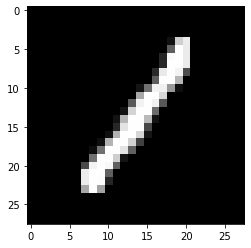

In [265]:
plt.imshow(query.reshape((28, 28)), cmap='gray')
plt.show()

In [245]:
model.predict_classes(X_train_ref[0].reshape(1,28,28))

array([1])

In [248]:
np.around(ni_train[1])

0.0

In [249]:
np.around(ni_train)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [255]:
# Novelty index of a test query
query = X_test[np.random.randint(X_test.shape[0], size=1), :]
ni_test = compute_novelty_index(query, deno, X_train_ref, model)

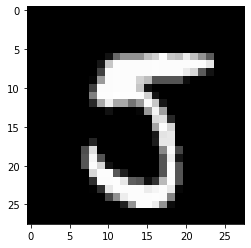

In [257]:
plt.imshow(query.reshape((28, 28)), cmap='gray')
plt.show()

In [258]:
model.predict_classes(query.reshape(1,28,28))

array([5])

In [259]:
np.around(ni_test[5])

5.0

In [260]:
np.around(ni_test)

array([0., 0., 0., 1., 0., 5., 0., 0., 0., 0.])

In [224]:
# Novelty index of a noise query
query = temp2
ni_noise = compute_novelty_index(query, deno, X_train_ref, model)

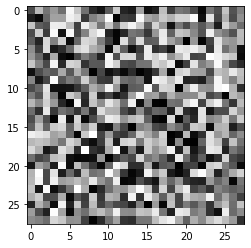

In [263]:
plt.imshow(query.reshape((28, 28)), cmap='gray')
plt.show()

In [261]:
model.predict_classes(temp2.reshape(1,28,28))

array([8])

In [238]:
np.around(ni_noise[8])

4458.0

In [239]:
np.around(ni_noise)

array([0.0000e+00, 0.0000e+00, 1.0000e+00, 1.9930e+03, 0.0000e+00,
       6.9957e+04, 0.0000e+00, 0.0000e+00, 4.4580e+03, 5.4600e+02])